In [13]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving 스크린샷 2020-12-12 오후 2.57.49.png to 스크린샷 2020-12-12 오후 2.57.49.png
User uploaded file "스크린샷 2020-12-12 오후 2.57.49.png" with length 225477 bytes


In [14]:
from IPython.display import Image 

# 언어 모델  
  
확률적 언어 모델은 이전에 입력된 단어 시퀀스로부터 다음에 입력될 단어 시퀀스를 예측하는 작업이다.

## 1. Motivation  
  
- 효율적 복잡도  
  
  - 본고에서는 분산 표현 distributed representation을 도입함으로써 소위 '차원의 저주'라 불리는 문제를 해소한다. 기존의 언어 모델 방법에서는 입력되는 단어의 수가 커짐에 따라 컴퓨터가 계산해야 할 모수parameter의 개수가 기하급수적으로 커지는 곤경을 가졌다. 여기서 사용되던 방법은 원핫 인코딩 방법인데, 분산 표현은 이것에 대한 효과적인 개선책이다. 저자는 원핫 인코딩을 분산 표현으로 대체함으로써 효과적으로 계산 복잡도를 낮출 수 있음을 주장한다.

In [ ]:
"""

원핫 인코딩과 분산 표현 각각을 코딩해보고 이들의 차이를 알아보자.

"""

import numpy as np
from copy import deepcopy

sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list)) # 중복 단어 없애기 위해 set 사용 
V = len(word_list) # 15 개

char_to_integer = dict((i, c) for c, i in enumerate(word_list))
print('(1) 각 word의 index: ',char_to_integer) # check

word_to_integer = list(i for i in range(V))
print('\n(2) word to integer: ', word_to_integer)    

onehot_vector = list() # 초기화
onehot_vectors_set = list()

for i in word_to_integer: 
    
    del onehot_vector[:] 
    
    for index in range(V): 
        if word_to_integer[i] == index:
        
            onehot_vector.append(1)

        else:
            onehot_vector.append(0)

    onehot_vectors_set.append(deepcopy(onehot_vector))


onehot_vectors_set = np.array(onehot_vectors_set) # matmul 연산을 위해 set을 array화 해준다, 15 x 15

print("\n(3) onehot_vectors_set\n\n",onehot_vectors_set)

EMBEDDING_SIZE = 2
C = np.random.rand(V, EMBEDDING_SIZE) # random_feature_matrix, V=15, m = 2

word_features_vectors = np.matmul(onehot_vectors_set, C) # 이것을 lookup table 과정이라고 부르기도 한다.
print(word_features_vectors,'\n')
print('(4) shape이 줄어든다:',onehot_vectors_set.shape,'===>',word_features_vectors.shape)
X = word_features_vectors

(1) 각 word의 index:  {'is': 0, 'study': 1, 'The': 2, 'dislike': 3, 'Many': 4, 'students': 5, 'to': 6, 'based': 7, 'want': 8, 'many': 9, 'engineering': 10, 'on': 11, 'But': 12, 'the': 13, 'mathematics': 14}

(2) word to integer:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

(3) onehot_vectors_set

 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
[[0.85724257 0.1859756 ]
 [0.09759773 0.25787092]
 [0.90106584 0.22173273]
 [0.50518339 0.40998946]
 [0.63298338 0.56057118]
 [0.65811263 0.35376825]
 [0.54625558 0.76342625]
 [0.59649934 0.89372457]

## 2 모델에게 조건적 확률의 곱 표현 학습시키기

### 2.1 조건적 확률의 곱  
  
모델에게 언어 모델 작업을 수행시키기 위해, 우리는 각각의 랜덤 변수가 다양한 특성nature를 갖는 집합 $z1, ..., zn$의 결합 확률을 조건적 확률의 곱으로 표현한 뒤 학습시킬 것이다.   
  
$$\hat{P}(Z_1 = z_1, ..., Z_n = z_n) = \prod_i \hat{P}(Z_i = z_i|g_i(Z_{i-1}, Z_{i-2} = z_{i-2}, ..., Z_1 = z_1))$$
여기서 $g(.)$는, 임의의 order에서, 이전 Z의 값($Z_{i-1})$을 고려할 때 $Z_i$의 조건적 확률의 분포를 계산해준다


#### 어떻게 자연 언어가 조건적 확률의 곱으로 표현되는가? (예시)
$P(Attitude\_is\_everything``)$을 문장 $'Attitude'\_'is'\_'everything'$에 대한 확률이라고 해보자. 그리고 이 문장 내의 단어들을 다음 같이 스플릿해보자:



$P('Attitude',\ 'is',\ 'everything')$
Given that the conditional probability principle $P(A,B)=P(A|B)P(B)$,



$P(A|B,C)\ =\ \frac{P(A,B,C)}{P(B,C)}$
Furthermore, by this conclusion, it follows that

$P(A,B,C)=P(A|B,C)*P(B,C)=P(A|B,C)*P(B|C)*P(C)$ where $(A, B) = (A \And B)$



So, we can regard 
$P('Attitude\_is\_everything')$ $=$ $P('everything'|'is','Attitude')*P('is'|'Attitude')*P('Attitude')$ in the same form above.

## 3. 훈련 시키기

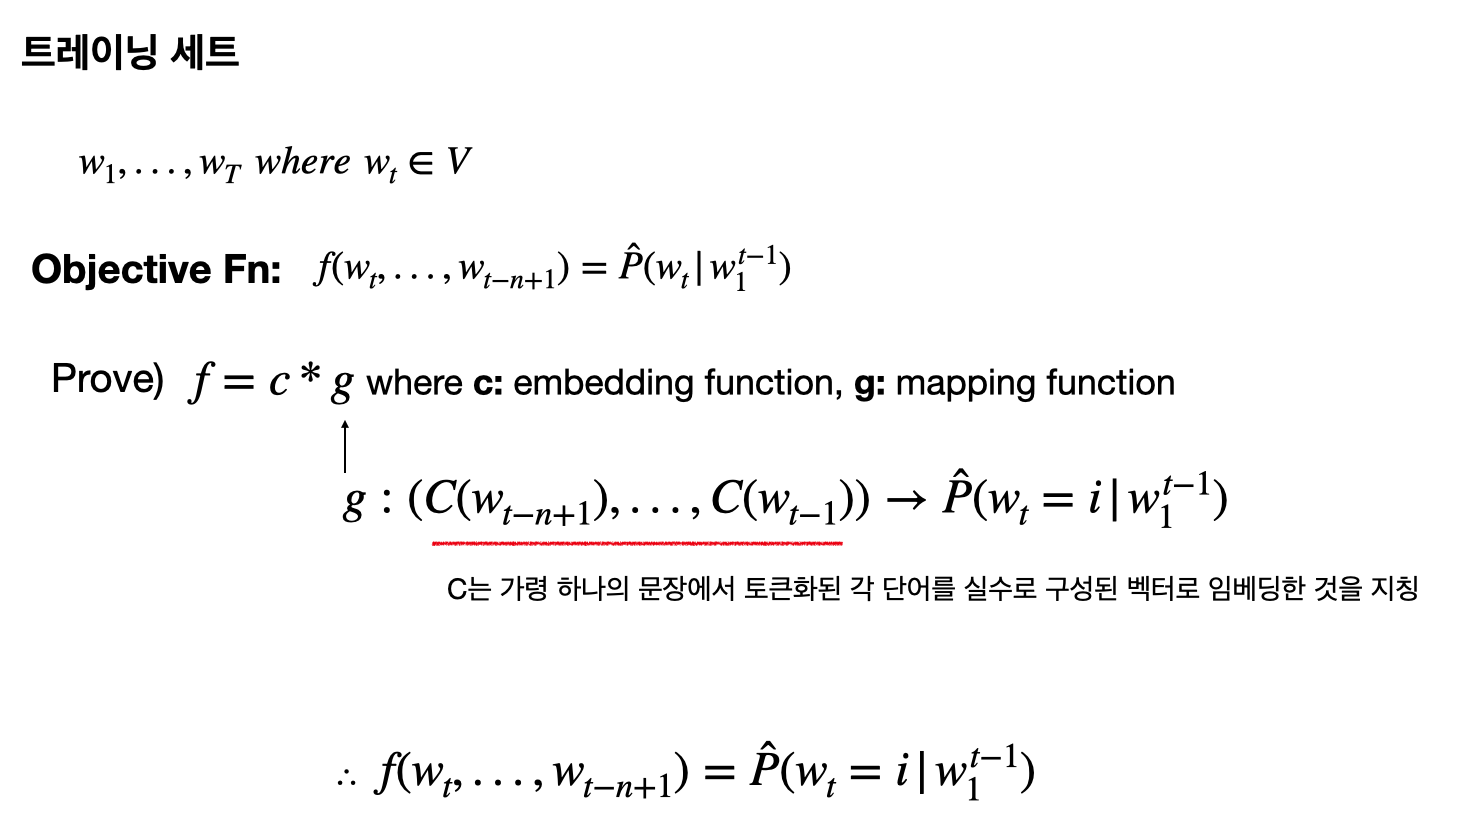

In [11]:
Image('/content/스크린샷 2020-12-12 오후 2.51.35.png',width=600)

## 4. 모델 아키텍처

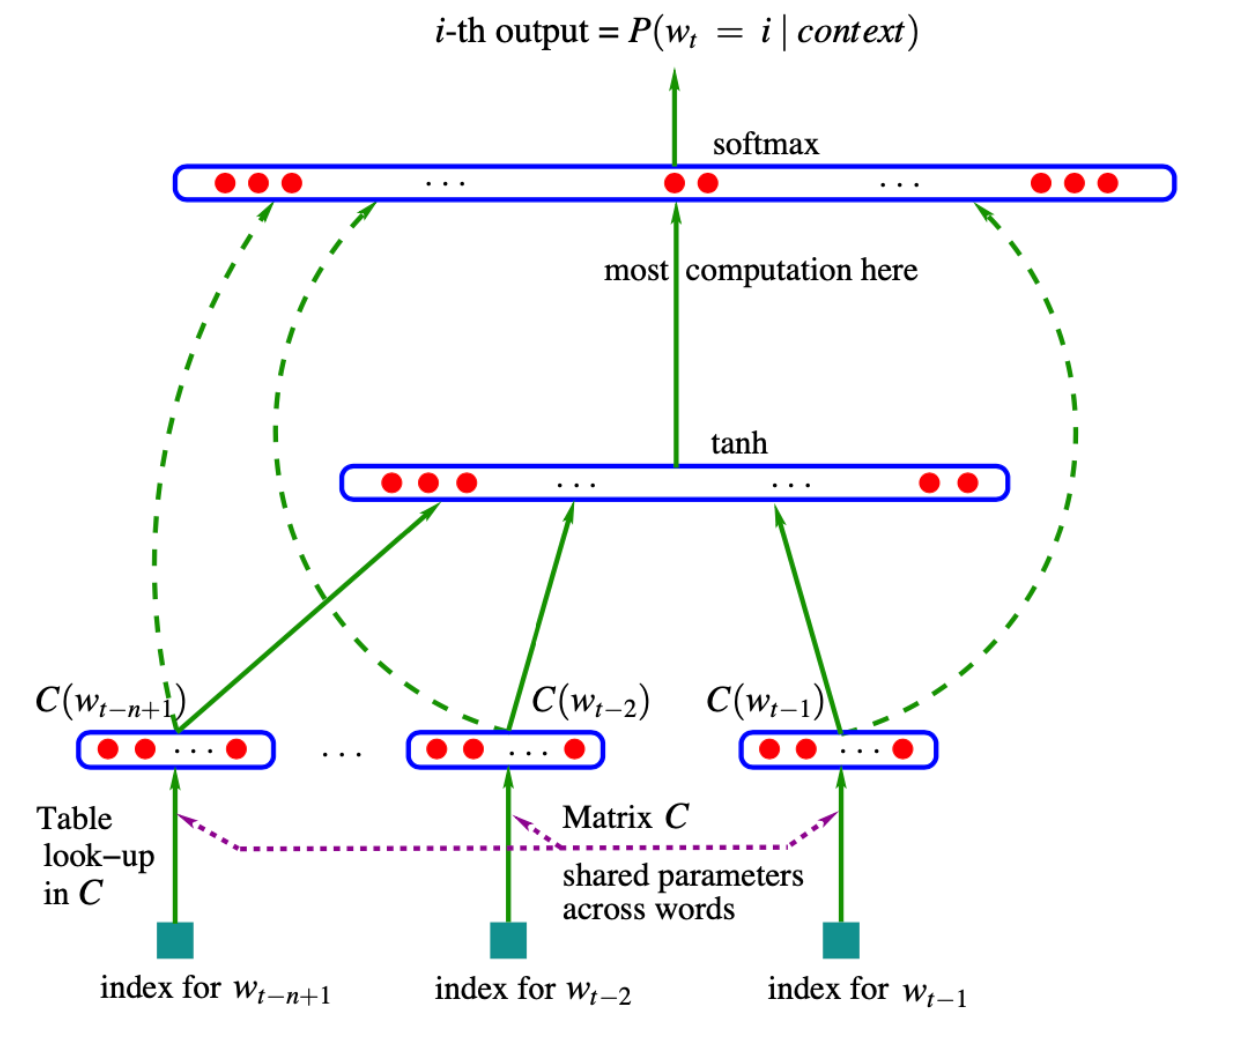

In [15]:
Image('/content/스크린샷 2020-12-12 오후 2.57.49.png',width=600)

## 5 코드

일러두기:  
- loss, optimizer는 다른 것을 택해도 된다.

- Raw Text: 플라톤의 '국가' 일부 발췌

In [17]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
raw = """
Then, Polemarchus, the conclusion will be that for a bad judge
of character it will often be right to injure his friends, when they
really are rogues, and to help his enemies, when they really are
honest men-the exact opposite of what we took Simonides to
mean.
That certainly does follow, he said. We must shift our ground.
Perhaps our definition of friend and enemy was wrong.
What definition, Polemarchus?
We said a friend was one whom we believe to be an honest man.
And how are we to define him now?
As one who really is honest as well as seeming so. If he merely
seems so, he will be only a seeming friend. And the same will
apply to enemies.
On this showing, then, it is the good people that will be our
friends, the wicked our enemies.
Yes.
You would have us, in fact, add something to our original definition of justice: it will not mean merely doing good to friends and
harm to enemies, but doing good to friends who are good, and
harm to enemies who are wicked.
Yes, I think that is all right.
Can it really be a just man's business to harm any human being?
Certainly; it is right for him to harm bad men who are his
enemies.
But does not harming a horse or a dog mean making it a worse
horse or dog, so that each will be a less perfect creature in its own
special way?
Yes.
Isn't that also true of human beings-that to harm them means
making them worse men by the standard of human excellence?
Yes.
And is not justice a peculiarly human excellence?
Undoubtedly.
To harm a man, then, must mean making him less just.
I suppose so
""".split()

trigram 예시  
  
  - ngram은 언어모델에서 n 개의 단어를 고려하여 다음 단어를 예측하는 작업을 뜻한다. 아래는 2 개의 단어를 가지고 다음 단어를 고려하는 수행의 예시를 보여준다.

In [24]:
trigram = [([raw[i],raw[i+1]],raw[i+2])
for i in range(len(raw)-2)]

print(trigram[:3])

[(['Then,', 'Polemarchus,'], 'the'), (['Polemarchus,', 'the'], 'conclusion'), (['the', 'conclusion'], 'will')]


전처리 작업  
  
컴퓨터는 우리 인간이 사용하는 자연 언어를 이해할 수 없다. 우리는 자연언어에 인덱스를 부여함으로써 컴퓨터에게 우리의 언어를 계산하게 해준다.

In [22]:
vocab = set(raw)
w2i = {w:i for i,w in enumerate(vocab)}
print('length: ',len(w2i))

length:  158


In [28]:
import matplotlib.pyplot as plt

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NgramLM(nn.Module):

    def __init__(self, vocab_size, embedding_size, context_size):

        super(NgramLM,self).__init__()
        self.embeddings = nn.Embedding(vocab_size,embedding_size)
        self.linear1 = nn.Linear(context_size*embedding_size,128)
        self.linear2 = nn.Linear(128, vocab_size) # to revover vectors into words

    def forward(self, inputs):

        embeds = self.embeddings(inputs).view((1,-1)) # reshape (flattening)
        out = F.selu(self.linear1(embeds)) # 최근에 공부했던 향상된 relu인 selu를 사용해보자
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

loss_fn = nn.NLLLoss()

# generate model

model = NgramLM(len(vocab),EMBEDDING_DIM,CONTEXT_SIZE)
optimizer = optim.Adam(model.parameters(), lr= 0.001)

losses=[]
epochs=[]
for epoch in range(301):

    total_loss = 0

    for context, target in bigram:

        # (1) 입력값이 모델을 통과하게 하자. 단어 -->정수 인덱스 --> 텐서화
        context_idxs = torch.tensor([w2i[w] for w in context], dtype = torch.long)

        # (2) torch는 grads를 축적한다. 새로운 인스턴스를 지나기 전에, 이전 인스턴스의 grads를 0으로 초기화하자.
        model.zero_grad()

        # (3) 다음 단어에 대한 로그 확률 구하기
        log_probs = model(context_idxs) # 위에서 기술한 모델은 입력으로부터 로그 확률을 구하게 설계되었다.

        # (4) 비용 함수 구하기 --> 타겟을 텐서화
        loss = loss_fn(log_probs, torch.tensor([w2i[target]], dtype=torch.long))

        # (5) 역전파, grads 업데이트
        loss.backward()
        optimizer.step()

        # Tensor --> Python number
        total_loss += loss.item()
    if epoch % 50 == 0:
            print(epoch,'epoch, loss:',total_loss)

            losses.append(total_loss)
            epochs.append(epochs)

0 epoch, loss: 1504.5602111816406
50 epoch, loss: 51.77821867367311
100 epoch, loss: 40.50702831455487
150 epoch, loss: 37.03994022412726
200 epoch, loss: 35.323577220274174
250 epoch, loss: 34.33388996141812
300 epoch, loss: 33.56469420785253


## 학습 과정 시각화

In [ ]:
plt.plot(epochs,losses)
plt.title('Language Model')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()